In [1]:
import matplotlib.pyplot as plt
import math

from timeit import default_timer as timer
from torch.cuda import is_available as gpu_available
from numpy import linspace, meshgrid

use_gpu = gpu_available()

if use_gpu:
  from torch import roll, maximum, minimum, abs, min
  from torch import sqrt, exp, sin, pi
  from torch import ones, zeros
  from torch import from_numpy
else:
  from numpy import roll, maximum, minimum, abs, min
  from numpy import sqrt, exp, sin, pi
  from numpy import ones, zeros






<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

ran main
each grid size ran 3 runs, each run simulated 0.1 seconds.
Grid: (16, 16)
	avg runtime: 0.0002618069620484946s
Grid: (32, 32)
	avg runtime: 0.0007793912908092654s
Grid: (64, 64)
	avg runtime: 0.005974342827160328s
Grid: (128, 128)
	avg runtime: 0.05069375279012328s
Grid: (256, 256)
	avg runtime: 0.6671604227777791s
Grid: (512, 512)
	avg runtime: 15.944468325888893s
Grid: (1024, 1024)
	avg runtime: 425.7960745926666s
[2.61806962e-04 7.79391291e-04 5.97434283e-03 5.06937528e-02
 6.67160423e-01 1.59444683e+01 4.25796075e+02]


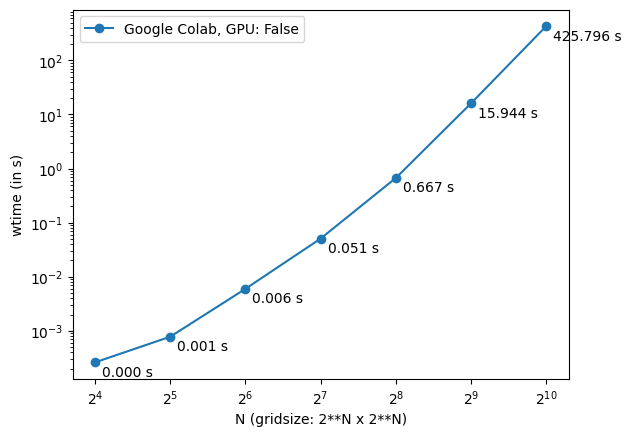

In [2]:
"""
Create Your Own Finite Volume Fluid Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz

Simulate the Kelvin Helmholtz Instability
In the compressible Euler equations

"""


def getConserved( rho, vx, vy, P, gamma, vol ):
    """
    Calculate the conserved variable from the primitive
    rho      is matrix of cell densities
    vx       is matrix of cell x-velocity
    vy       is matrix of cell y-velocity
    P        is matrix of cell pressures
    gamma    is ideal gas gamma
    vol      is cell volume
    Mass     is matrix of mass in cells
    Momx     is matrix of x-momentum in cells
    Momy     is matrix of y-momentum in cells
    Energy   is matrix of energy in cells
    """
    Mass   = rho * vol
    Momx   = rho * vx * vol
    Momy   = rho * vy * vol
    Energy = (P/(gamma-1) + 0.5*rho*(vx**2+vy**2))*vol

    return Mass, Momx, Momy, Energy


def getPrimitive( Mass, Momx, Momy, Energy, gamma, vol ):
    """
    Calculate the primitive variable from the conservative
    Mass     is matrix of mass in cells
    Momx     is matrix of x-momentum in cells
    Momy     is matrix of y-momentum in cells
    Energy   is matrix of energy in cells
    gamma    is ideal gas gamma
    vol      is cell volume
    rho      is matrix of cell densities
    vx       is matrix of cell x-velocity
    vy       is matrix of cell y-velocity
    P        is matrix of cell pressures
    """
    rho = Mass / vol
    vx  = Momx / rho / vol
    vy  = Momy / rho / vol
    P   = (Energy/vol - 0.5*rho * (vx**2+vy**2)) * (gamma-1)

    return rho, vx, vy, P


def getGradient(f, dx):
    """
    Calculate the gradients of a field
    f        is a matrix of the field
    dx       is the cell size
    f_dx     is a matrix of derivative of f in the x-direction
    f_dy     is a matrix of derivative of f in the y-direction
    """
    # directions for roll()
    R = -1   # right
    L = 1    # left

    f_dx = ( roll(f, R, 0) - roll(f, L, 0) ) / (2*dx)
    f_dy = ( roll(f, R, 1) - roll(f, L, 1) ) / (2*dx)

    return f_dx, f_dy


def slopeLimit(f, dx, f_dx, f_dy):
    """
    Apply slope limiter to slopes
    f        is a matrix of the field
    dx       is the cell size
    f_dx     is a matrix of derivative of f in the x-direction
    f_dy     is a matrix of derivative of f in the y-direction
    """
    # directions for roll()
    R = -1   # right
    L = 1    # left

    f_dx = maximum(0., minimum(1., ( (f-roll(f, L, 0))/dx)/(f_dx + 1.0e-8*(f_dx==0)))) * f_dx
    f_dx = maximum(0., minimum(1., (-(f-roll(f, R, 0))/dx)/(f_dx + 1.0e-8*(f_dx==0)))) * f_dx
    f_dy = maximum(0., minimum(1., ( (f-roll(f, L, 1))/dx)/(f_dy + 1.0e-8*(f_dy==0)))) * f_dy
    f_dy = maximum(0., minimum(1., (-(f-roll(f, R, 1))/dx)/(f_dy + 1.0e-8*(f_dy==0)))) * f_dy

    return f_dx, f_dy


def extrapolateInSpaceToFace(f, f_dx, f_dy, dx):
    """
    Calculate the gradients of a field
    f        is a matrix of the field
    f_dx     is a matrix of the field x-derivatives
    f_dy     is a matrix of the field y-derivatives
    dx       is the cell size
    f_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
    f_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis
    f_YL     is a matrix of spatial-extrapolated values on `left' face along y-axis
    f_YR     is a matrix of spatial-extrapolated values on `right' face along y-axis
    """
    # directions for roll()
    R = -1   # right
    L = 1    # left

    f_XL = f - f_dx * dx/2
    f_XL = roll(f_XL,R,0)
    f_XR = f + f_dx * dx/2

    f_YL = f - f_dy * dx/2
    f_YL = roll(f_YL,R,1)
    f_YR = f + f_dy * dx/2

    return f_XL, f_XR, f_YL, f_YR


def applyFluxes(F, flux_F_X, flux_F_Y, dx, dt):
    """
    Apply fluxes to conserved variables
    F        is a matrix of the conserved variable field
    flux_F_X is a matrix of the x-dir fluxes
    flux_F_Y is a matrix of the y-dir fluxes
    dx       is the cell size
    dt       is the timestep
    """
    # directions for roll()
    R = -1   # right
    L = 1    # left

    # update solution
    F += - dt * dx * flux_F_X
    F +=   dt * dx * roll(flux_F_X, L, 0)
    F += - dt * dx * flux_F_Y
    F +=   dt * dx * roll(flux_F_Y, L, 1)

    return F


def getFlux(rho_L, rho_R, vx_L, vx_R, vy_L, vy_R, P_L, P_R, gamma):
    """
    Calculate fluxed between 2 states with local Lax-Friedrichs/Rusanov rule
    rho_L        is a matrix of left-state  density
    rho_R        is a matrix of right-state density
    vx_L         is a matrix of left-state  x-velocity
    vx_R         is a matrix of right-state x-velocity
    vy_L         is a matrix of left-state  y-velocity
    vy_R         is a matrix of right-state y-velocity
    P_L          is a matrix of left-state  pressure
    P_R          is a matrix of right-state pressure
    gamma        is the ideal gas gamma
    flux_Mass    is the matrix of mass fluxes
    flux_Momx    is the matrix of x-momentum fluxes
    flux_Momy    is the matrix of y-momentum fluxes
    flux_Energy  is the matrix of energy fluxes
    """

    # left and right energies
    en_L = P_L/(gamma-1)+0.5*rho_L * (vx_L**2+vy_L**2)
    en_R = P_R/(gamma-1)+0.5*rho_R * (vx_R**2+vy_R**2)

    # compute star (averaged) states
    rho_star  = 0.5*(rho_L + rho_R)
    momx_star = 0.5*(rho_L * vx_L + rho_R * vx_R)
    momy_star = 0.5*(rho_L * vy_L + rho_R * vy_R)
    en_star   = 0.5*(en_L + en_R)

    P_star = (gamma-1)*(en_star-0.5*(momx_star**2+momy_star**2)/rho_star)

    # compute fluxes (local Lax-Friedrichs/Rusanov)
    flux_Mass   = momx_star
    flux_Momx   = momx_star**2/rho_star + P_star
    flux_Momy   = momx_star * momy_star/rho_star
    flux_Energy = (en_star+P_star) * momx_star/rho_star

    # find wavespeeds
    C_L = sqrt(gamma*P_L/rho_L) + abs(vx_L)
    C_R = sqrt(gamma*P_R/rho_R) + abs(vx_R)
    C = maximum( C_L, C_R )

    # add stabilizing diffusive term
    flux_Mass   -= C * 0.5 * (rho_L - rho_R)
    flux_Momx   -= C * 0.5 * (rho_L * vx_L - rho_R * vx_R)
    flux_Momy   -= C * 0.5 * (rho_L * vy_L - rho_R * vy_R)
    flux_Energy -= C * 0.5 * ( en_L - en_R )

    return flux_Mass, flux_Momx, flux_Momy, flux_Energy


def main(N=128, tEnd=2, plotRealTime=False):
    """ Finite Volume simulation """

    # Simulation parameters
    N                      = N # resolution
    boxsize                = 1.
    gamma                  = 5/3 # ideal gas gamma
    courant_fac            = 0.4
    t                      = 0
    tEnd                   = tEnd
    tOut                   = 0.02 # draw frequency
    useSlopeLimiting       = False
    plotRealTime = plotRealTime # switch on for plotting as the simulation goes along

    # Mesh
    dx = boxsize / N
    vol = dx**2
    xlin = linspace(0.5*dx, boxsize-0.5*dx, N)
    Y, X = meshgrid( xlin, xlin )
    if use_gpu:
        # xlin = from_numpy(xlin)
        X = from_numpy(X)
        Y = from_numpy(Y)

    # Generate Initial Conditions - opposite moving streams with perturbation
    w0 = 0.1
    sigma = 0.05/math.sqrt(2.)
    rho = 1. + (abs(Y-0.5) < 0.25)
    vx = -0.5 + (abs(Y-0.5)<0.25)
    vy = w0*sin(4*pi*X) * ( exp(-(Y-0.25)**2/(2 * sigma**2)) + exp(-(Y-0.75)**2/(2*sigma**2)) )
    P = 2.5 * ones(X.shape)

    # Get conserved variables
    Mass, Momx, Momy, Energy = getConserved( rho, vx, vy, P, gamma, vol )

    # prep figure
    fig = plt.figure(figsize=(4,4), dpi=80)
    outputCount = 1

    if use_gpu:
        Mass = Mass.cuda()
        Momx = Momx.cuda()
        Momy = Momy.cuda()
        Energy = Energy.cuda()

    # Simulation Main Loop
    while t < tEnd:

        # get Primitive variables
        rho, vx, vy, P = getPrimitive( Mass, Momx, Momy, Energy, gamma, vol )

        # get time step (CFL) = dx / max signal speed
        dt = courant_fac * min( dx / (sqrt( gamma*P/rho ) + sqrt(vx**2+vy**2)) )
        plotThisTurn = False

        if t + dt > outputCount*tOut and plotRealTime:
            dt = outputCount*tOut - t
            plotThisTurn = True

        # calculate gradients
        rho_dx, rho_dy = getGradient(rho, dx)
        vx_dx,  vx_dy  = getGradient(vx,  dx)
        vy_dx,  vy_dy  = getGradient(vy,  dx)
        P_dx,   P_dy   = getGradient(P,   dx)

        # slope limit gradients
        if useSlopeLimiting:
            rho_dx, rho_dy = slopeLimit(rho, dx, rho_dx, rho_dy)
            vx_dx,  vx_dy  = slopeLimit(vx , dx, vx_dx,  vx_dy )
            vy_dx,  vy_dy  = slopeLimit(vy , dx, vy_dx,  vy_dy )
            P_dx,   P_dy   = slopeLimit(P  , dx, P_dx,   P_dy  )

        # extrapolate half-step in time
        rho_prime = rho - 0.5*dt * ( vx * rho_dx + rho * vx_dx + vy * rho_dy + rho * vy_dy)
        vx_prime  = vx  - 0.5*dt * ( vx * vx_dx + vy * vx_dy + (1/rho) * P_dx )
        vy_prime  = vy  - 0.5*dt * ( vx * vy_dx + vy * vy_dy + (1/rho) * P_dy )
        P_prime   = P   - 0.5*dt * ( gamma*P * (vx_dx + vy_dy)  + vx * P_dx + vy * P_dy )

        # extrapolate in space to face centers
        rho_XL, rho_XR, rho_YL, rho_YR = extrapolateInSpaceToFace(rho_prime, rho_dx, rho_dy, dx)
        vx_XL,  vx_XR,  vx_YL,  vx_YR  = extrapolateInSpaceToFace(vx_prime,  vx_dx,  vx_dy,  dx)
        vy_XL,  vy_XR,  vy_YL,  vy_YR  = extrapolateInSpaceToFace(vy_prime,  vy_dx,  vy_dy,  dx)
        P_XL,   P_XR,   P_YL,   P_YR   = extrapolateInSpaceToFace(P_prime,   P_dx,   P_dy,   dx)

        # compute fluxes (local Lax-Friedrichs/Rusanov)
        flux_Mass_X, flux_Momx_X, flux_Momy_X, flux_Energy_X = getFlux(rho_XL, rho_XR, vx_XL, vx_XR, vy_XL, vy_XR, P_XL, P_XR, gamma)
        flux_Mass_Y, flux_Momy_Y, flux_Momx_Y, flux_Energy_Y = getFlux(rho_YL, rho_YR, vy_YL, vy_YR, vx_YL, vx_YR, P_YL, P_YR, gamma)

        # update solution
        Mass   = applyFluxes(Mass, flux_Mass_X, flux_Mass_Y, dx, dt)
        Momx   = applyFluxes(Momx, flux_Momx_X, flux_Momx_Y, dx, dt)
        Momy   = applyFluxes(Momy, flux_Momy_X, flux_Momy_Y, dx, dt)
        Energy = applyFluxes(Energy, flux_Energy_X, flux_Energy_Y, dx, dt)

        # update time
        t += dt

        # plot in real time
        if ((plotRealTime and plotThisTurn) or (t >= tEnd)) and False:
            rho, _, _, _ = getPrimitive( Mass, Momx, Momy, Energy, gamma, vol)
            if use_gpu:
                rho = rho.cpu()

            plt.cla()
            plt.imshow(rho.T)
            plt.clim(0.8, 2.2)
            ax = plt.gca()
            ax.invert_yaxis()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_aspect('equal')
            plt.pause(0.001)
            outputCount += 1


    # Save figure
    plt.savefig('finitevolume.png',dpi=240)
    plt.show()

    return 0



def timed(f, *args, **kwargs):
    t0 = timer()
    f(*args, **kwargs)
    t1 = timer()
    return t1 - t0


def run_function_as_experiment(f, lbound, ubound, num_runs, tEnd):
    grid_sizes = [2 ** i for i in range(lbound, ubound)]
    wtimes = zeros(len(grid_sizes))
    for i, grid_size in enumerate(grid_sizes):
        for _ in range(num_runs):
            wtimes[i] += timed(f, N=grid_size, tEnd=tEnd)
        wtimes /= num_runs

    print(f"ran {f.__name__}")
    print(f"each grid size ran {num_runs} runs, each run simulated {tEnd} seconds.")
    for i, j in zip(grid_sizes, wtimes):
        print(f"Grid: ({i}, {i})\n\tavg runtime: {j}s")
    print(wtimes)
    # plt.plot(grid_sizes, wtimes, label=f"{f.__name__} (m1 (16') macbook pro, 2021)", marker='o')
    plt.plot(grid_sizes, wtimes, label=f"Google Colab, GPU: {use_gpu}", marker='o')

    for i,j in zip(grid_sizes, wtimes):
        plt.annotate("%.3f s" % j, xy=(i,j), xytext=(5,-10), textcoords="offset points")


if __name__== "__main__":
    run_function_as_experiment(main, 4, 10+1, 3, 0.1)

    plt.xscale("log", base=2)
    plt.xlabel("N (gridsize: 2**N x 2**N)")

    plt.yscale("log", base=10)
    plt.ylabel("wtime (in s)")
    plt.legend()

    plt.show()

